Environment: Python 3
Jupyter notebook Libraries used:

- pandas for dataframe manipulation
- numpy for scientific computations
- math to use sin, cos, tan, randian functions
- html.parser for html data extraction
- xml.etree for xml data extraction
- datetime to extract hour, minutes and seconds from time
- pandas summary for getting data summary 
- 


- matplotlib and seaborn for visualisations
- image to include screenshots in notebook

### This report contains following sections -

#### Task 1

1. Importing the data and setting the default values.
2. Calculating the distances and id for nearest shopping center, hospital, supermarket and train station using harvesine distance.
3. Travel time to CBD
4. Tranfer Flag
5. Suburb imputation for all properties.

## Task 1: Data Integration (60%)
In this task, you are required to integrate the input datasets (i.e., 7 datasets including ​hospitals​, supermarkets​, ​shopping centers​, ​real estate files (one XML and one Json), Vic_suburb_boundary​, and ​GTFS_Melbourne_Train_Information files) into one dataset with the following schema.

In [838]:
from html.parser import HTMLParser
import codecs
import pandas as pd
import xml.etree.cElementTree as et
from lxml import etree
import re
import numpy as np
# Warnings disabled
pd.options.mode.chained_assignment = None

import geopandas
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import math
from urllib.request import urlopen
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn import preprocessing

### Loading Shoping center HTML data

- This html data will be loaded into pandas data frame
- It have three columns corrosponding to:
    - shopping center id
    - shopping latitude
    - shopping longitude

In [839]:
df_temp = pd.read_html('/Users/shubhamsingh/Documents/30145945/shopingcenters.html')
shoping_df = df_temp[0]

In [840]:
shoping_df.head()

,Unnamed: 0,sc_id,lat,lng
0,0,SC_001,-37.767915,145.041790
1,1,SC_002,-37.819375,145.171472
2,2,SC_003,-37.971131,145.089065
3,3,SC_004,-35.280406,149.132550
4,4,SC_005,-37.574572,144.920451


### Loading GTFS data

- GTFS stands for General Transit Feed Specification. 
- GTFS feeds are well-known and useful datasets that describe transit data of public transport agencies. 
- GTFS ”feeds” allow public transit agencies to publish their transit data and developers to write applications that consume that data in an interoperable way.

In [841]:
df_stops = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/stops.txt')
df_stop_times = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/stop_times.txt')
df_trips = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/trips.txt')
df_shapes = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/shapes.txt')
df_routes = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/routes.txt')
df_calendar_dt = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/calendar_dates.txt')
df_calendar = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/calendar.txt')
df_agency = pd.read_csv('/Users/shubhamsingh/Documents/1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/agency.txt')

### Loading Real state json data

- the given dataset is in json format, will convert this data into pandas dataframe.
- Data has infromation about the property including:
    - property loaction
    - property address
    - price of the property 
    - year of build and so on.

In [842]:
real_state_json = pd.read_json('/Users/shubhamsingh/Documents/30145945/real_state.json')

In [843]:
real_state_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    1010 non-null   int64  
 1   lat            1010 non-null   float64
 2   lng            1010 non-null   float64
 3   addr_street    1010 non-null   object 
 4   price          1010 non-null   int64  
 5   property_type  1010 non-null   object 
 6   year           1010 non-null   int64  
 7   bedrooms       1010 non-null   int64  
 8   bathrooms      1010 non-null   int64  
 9   parking_space  1010 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 79.0+ KB


### Loading hospital pdf data

To read the pdf data into pandas dataframe we need use `tabula`. to use this library we need to install by using`!pip install tabula-py`.
- pdf data is in table formate which have information like:
    - hopital id (unique)
    - hopital location(lat, long)
    - hopital name

In [844]:
!pip install tabula-py

In [845]:
import tabula
 
file = "/Users/shubhamsingh/Documents/hospitals.pdf"
table = tabula.read_pdf(file, pages = "all", multiple_tables = True)

In [846]:
data = pd.concat(table)
# df_hospitals.drop(['Unnamed: 0','Unnamed: 1','Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5'], axis = 1, inplace = True)
df_hospitals = data[['id','lat','lng','name']] # taking only required columns 
df_hospitals = df_hospitals.dropna() # dropping row which has nan values
df_hospitals.shape

(199, 4)

In [847]:
len(df_hospitals.id.unique())

199

### Reading real state xml data

- This real dataset is in xml format. but the format of the xml is not well defined. 
- Xml file contains some unwanted string which will create problem when we try to convert xml file to pandas dataframe.
- To get desired xml format string will convert the containt of the file into string.
- After converting into string will use regex for string extraction using `(?=<root>)(.*)(?=')`.
- This reges will get all the string from `<root>` to `</root>`.
- After that will use `XMLParser` to parse the xml data.

In [848]:
f = open('/Users/shubhamsingh/Documents/30145945/real_state.xml', "r")
file = f.read()

In [849]:
reg = re.compile(r"(?=<root>)(.*)(?=')")
xml_file = reg.findall(file)

parser = etree.XMLParser(recover=True)
xml_tree = etree.fromstring(xml_file[0], parser=parser)

- `xml_tree` contains all the tags together. by using block of code will get all the distinct tags and there values.
- It will also give the columns names and there order which will helps us creating dataframe.

In [850]:
list_of_all = []
for patient_element in xml_tree:
    print(patient_element)
    for j in patient_element:
        list_of_all.append(j.text)

print('Total value in list is:', len(list_of_all))

<Element property_id at 0x7f8174ef9180>
<Element lat at 0x7f8174ef9040>
<Element lng at 0x7f816bda2740>
<Element addr_street at 0x7f8174f07a80>
<Element price at 0x7f8174ef9180>
<Element property_type at 0x7f8174ef9040>
<Element year at 0x7f816bda2740>
<Element bedrooms at 0x7f8174f07a80>
<Element bathrooms at 0x7f8174ef9180>
<Element parking_space at 0x7f8174ef9040>
Total value in list is: 10030


- As we can see that total number of rows that list as is 10030 which is datarows and it aloso gives us order of the columns.
- We have total of 10 columns, that means each column has `10030/10 = 1003` data.
- We will get data for each row by using below block of code.

In [851]:
property_id = list_of_all[0:1003]
lat = list_of_all[1003:2006]
lng = list_of_all[2006:3009]
addr_street = list_of_all[3009:4012]
price = list_of_all[4012:5015]
property_type = list_of_all[5015:6018]
year = list_of_all[6018:7021]
bedrooms = list_of_all[7021:8024]
bathrooms = list_of_all[8024:9027]
parking_space = list_of_all[9027:10030]

In [852]:
df_real_xml = pd.DataFrame(
    {'property_id': property_id,
     'lat': lat,
     'lng': lng,
     'addr_street': addr_street,
     'price': price,
     'property_type': property_type,
     'year': year,
     'bedrooms': bedrooms,
     'bathrooms': bathrooms,
     'parking_space' : parking_space
    })
df_real_xml.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,68741,-37.856149,145.037211,11 Eva Street,15720000,house,2014,3,1,0
1,19266,-37.669824,144.933401,9 Morwell Crescent,2224000,house,2012,3,1,1
2,3063,-37.815886799999994,144.8882819,20 Canterbury Street,15540000,house,2012,3,2,2
3,1685,-37.808658,144.88399099999998,112 Williamstown Road,9600000,house,2015,3,1,2
4,45135,-37.707832,145.088287,468 Greensborough Road,5715000,house,2015,5,3,0


In [853]:
# changing the data types for correct output.
df_real_xml = df_real_xml.astype({"property_id": np.int64, "price": np.int64, 
                "year": np.int64, "bedrooms": np.int64, "parking_space": np.int64, 
                "bathrooms" : np.int64, "lat":np.float64 ,"lng":np.float64})


In [854]:
df_real_xml.isnull().sum()

property_id      0
lat              0
lng              0
addr_street      0
price            0
property_type    0
year             0
bedrooms         0
bathrooms        0
parking_space    0
dtype: int64

In [855]:
# combinh two read state data
df_real = pd.concat([df_real_xml, real_state_json])

# dropping duplicated row base on propertu id as it is unique.
df_real.drop_duplicates(subset='property_id', keep='first', inplace = True)

df_real.reset_index(inplace=True)

# dropping index
df_real = df_real.drop('index', axis=1)
df_real.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,68741,-37.856149,145.037211,11 Eva Street,15720000,house,2014,3,1,0
1,19266,-37.669824,144.933401,9 Morwell Crescent,2224000,house,2012,3,1,1
2,3063,-37.815887,144.888282,20 Canterbury Street,15540000,house,2012,3,2,2
3,1685,-37.808658,144.883991,112 Williamstown Road,9600000,house,2015,3,1,2
4,45135,-37.707832,145.088287,468 Greensborough Road,5715000,house,2015,5,3,0


### Loading supermarket xlsx data

- the given dataset is in xlsx format, will convert this data into pandas dataframe.
- Data has infromation about the supermarket including:
    - supermarket id
    - supermarket loaction
    - supermarket type

In [856]:
df_supermarkets = pd.read_excel('/Users/shubhamsingh/Documents/30145945/supermarkets.xlsx')

In [857]:
df_supermarkets.head()

,Unnamed: 0,id,lat,lng,type
0,0,S_001,-37.883978,144.735287,Woolworths
1,1,S_002,-41.161591,147.514797,Woolworths
2,2,S_003,-37.984078,145.077167,Woolworths
3,3,S_004,-37.707023,144.938740,Woolworths
4,4,S_005,-37.597670,144.938413,Woolworths


### Finding property Suburbs

- to find the suburb of each property, we have vic_suburb_boundary file given to us. 
- This file contains shapes files, to read this files will use geopandas. 
- We then get a datatframe which we named geo_dataset. In this dataframe, two columns are important to us- geometry and VIC_LOCA_2

In [858]:
geo_dataset= geopandas.read_file('/Users/shubhamsingh/Documents/vic_suburb_boundary') 
geo_dataset.head()#reading the shape file as a dataframe

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


- We will use the geometry column- which consists of polygons in order to determine the suburb and will match the same column in our real state data to combine two table. 
- If the polygon containts the co-ordinates of the property, we return the corresponding suburb name.

In [859]:
suburb=[]
lon=df_real['lng']
lat=df_real['lat']

for i in range(len(lon)):
    item=Point(lon[i], lat[i])
    suburb.append((geo_dataset[geo_dataset['geometry'].contains(item)].VIC_LOCA_2).to_string()) #checking if polygon contains point, if yes, suburb is returned in list

In [860]:
for i in range(len(suburb)):
    if suburb[i] is None:
        suburb[i]="not available"
    else:
        suburb[i]=re.sub(r'\d', '', suburb[i]).strip()

In [861]:
df_real['Suburb']=suburb #suburb list added to dataframe

In [862]:
# defining the structure of the dataframe
df_real = df_real[['property_id', 'lat', 'lng', 'addr_street', 'Suburb', 
                   'price', 'property_type', 'year', 'bedrooms', 'bathrooms', 'parking_space']]
df_real.head()

,property_id,lat,lng,addr_street,Suburb,price,property_type,year,bedrooms,bathrooms,parking_space
0,68741,-37.856149,145.037211,11 Eva Street,MALVERN,15720000,house,2014,3,1,0
1,19266,-37.669824,144.933401,9 Morwell Crescent,DALLAS,2224000,house,2012,3,1,1
2,3063,-37.815887,144.888282,20 Canterbury Street,YARRAVILLE,15540000,house,2012,3,2,2
3,1685,-37.808658,144.883991,112 Williamstown Road,KINGSVILLE,9600000,house,2015,3,1,2
4,45135,-37.707832,145.088287,468 Greensborough Road,GREENSBOROUGH,5715000,house,2015,5,3,0


Building the distance function used to calculate nearest hospital, train station, supermarker and shopping center.

In [863]:
import numpy as np
def haversine_np(lat1,lon1,lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6378 * c *1000
    return(km.round(2))

### New columns as mentioned in the specification

In [864]:
df_real['Shopping_center_id'] = "not available"
df_real['Distance_to_sc'] = 0
df_real['Train_station_id'] = 0
df_real['Distance_to_train_station'] = 0
df_real['travel_min_to_CBD'] = 0
df_real['Transfer_flag'] = -1
df_real['Hospital_id'] = "not available"
df_real['Distance_to_hospital'] = 0
df_real['Supermarket_id'] = "not available"
df_real['Distance_to_supermaket'] = 0


In [865]:
df_real.head()

,property_id,lat,lng,addr_street,Suburb,price,property_type,year,bedrooms,bathrooms,...,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermaket
0,68741,-37.856149,145.037211,11 Eva Street,MALVERN,15720000,house,2014,3,1,...,not available,0,0,0,0,-1,not available,0,not available,0
1,19266,-37.669824,144.933401,9 Morwell Crescent,DALLAS,2224000,house,2012,3,1,...,not available,0,0,0,0,-1,not available,0,not available,0
2,3063,-37.815887,144.888282,20 Canterbury Street,YARRAVILLE,15540000,house,2012,3,2,...,not available,0,0,0,0,-1,not available,0,not available,0
3,1685,-37.808658,144.883991,112 Williamstown Road,KINGSVILLE,9600000,house,2015,3,1,...,not available,0,0,0,0,-1,not available,0,not available,0
4,45135,-37.707832,145.088287,468 Greensborough Road,GREENSBOROUGH,5715000,house,2015,5,3,...,not available,0,0,0,0,-1,not available,0,not available,0


In [866]:
df_real.columns

Index(['property_id', 'lat', 'lng', 'addr_street', 'Suburb', 'price',
       'property_type', 'year', 'bedrooms', 'bathrooms', 'parking_space',
       'Shopping_center_id', 'Distance_to_sc', 'Train_station_id',
       'Distance_to_train_station', 'travel_min_to_CBD', 'Transfer_flag',
       'Hospital_id', 'Distance_to_hospital', 'Supermarket_id',
       'Distance_to_supermaket'],
      dtype='object')

## Calculating minimum distance to Shopping center

I have iterrated through the datafram picking a property id and calculating the distance of all the shopping centers from the property and then taking the minimum of the distance and imputing the corresponding sc_id of the same to the data frame.

In [867]:
import math
m = 0
dict1 = {}
for (j, row2) in df_real.iterrows():
    lat_p = float(row2['lat'])
    lng_p = float(row2['lng'])
    prop_id = row2['property_id']
    list_d = []

    dict2 = {}
    for (i, row) in shoping_df.iterrows():
        lat_s = float(row['lat'])
        lng_s = float(row['lng'])
        sc_id = row['sc_id']
        dist = haversine_np(lat_p,lng_p,lat_s,lng_s)
        list_d.append(dist)

        dict2[dist] = sc_id

    list_d.sort()

    dis_fin = list_d[0]

    sc_id = dict2[dis_fin]

    if math.isnan(dis_fin):
        None
    else:    
        df_real.loc[j,'Distance_to_sc'] = dis_fin
        df_real.loc[j,'Shopping_center_id'] = sc_id
    m = m+1


## Calculating minimum distance to Supermarket 

I have iterrated through the dataframe picking a property id and calculating the distance of all the supermarkets from the property and then taking the minimum of the distance and imputing the corresponding supermarket id of the same to the data frame.

In [869]:
import math
m = 0
dict1 = {}
for (j, row2) in df_real.iterrows():
    lat_p = float(row2['lat'])
    lng_p = float(row2['lng'])
    prop_id = row2['property_id']
    list_d = []
    #list_j = []
    dict2 = {}
    for (i, row) in df_supermarkets.iterrows():
        lat_s = float(row['lat'])
        lng_s = float(row['lng'])
        sc_id = row['id']
        dist = haversine_np(lat_p,lng_p,lat_s,lng_s)
        list_d.append(dist)
        #dict1[prop_id] = sc_id,dist
        dict2[dist] = sc_id
    list_d.sort()
    #dis_fin = float(list_d[0])
    dis_fin = list_d[0]
    sc_id = dict2[dis_fin]
    if math.isnan(dis_fin):
        None
    else:    
        df_real.loc[j,'Distance_to_supermaket'] = dis_fin
        df_real.loc[j,'Supermarket_id'] = sc_id
    #df_2.iloc[m,11] = [id_sc for id_sc, val in dict2.items() if val == dis_fin]
    m = m+1

## Calculating minimum distance to hospital

I have iterrated through the dataframe picking a property id and calculating the distance of all the hospitals from the property and then taking the minimum of the distance and imputing the corresponding hospital id of the same to the data frame.

In [870]:
import math
m = 0
dict1 = {}
for j, row2 in df_real.iterrows():
    lat_p = float(row2['lat'])
    lng_p = float(row2['lng'])
    prop_id = row2['property_id']
    list_d = []
    #list_j = []
    dict2 = {}
    for i, row in df_hospitals.iterrows():
        lat_s = float(row['lat'])
        lng_s = float(row['lng'])
        sc_id = row['id']
        dist = haversine_np(lat_p,lng_p,lat_s,lng_s)
        list_d.append(dist)
        #dict1[prop_id] = sc_id,dist
        dict2[dist] = sc_id
    list_d.sort()
    #dis_fin = float(list_d[0])
    dis_fin = list_d[0]
    sc_id = dict2[dis_fin]
    if math.isnan(dis_fin):
        None
    else:    
        df_real.loc[j,'Distance_to_hospital'] = dis_fin
        df_real.loc[j,'Hospital_id'] = sc_id
    #df_2.iloc[m,11] = [id_sc for id_sc, val in dict2.items() if val == dis_fin]
    m = m+1
#print(max(list_j))

## Calculating minimum distance to Train station 

I have iterrated through the dataframe picking a property id and calculating the distance of all the stations from the property and then taking the minimum of the distance and imputing the corresponding train station id of the same to the data frame.

In [871]:
import math
m = 0
dict1 = {}
for (j, row2) in df_real.iterrows():
    lat_p = float(row2['lat'])
    lng_p = float(row2['lng'])
    prop_id = row2['property_id']
    list_d = []
    #list_j = []
    dict2 = {}
    for (i, row) in df_stops.iterrows():
        lat_s = float(row['stop_lat'])
        lng_s = float(row['stop_lon'])
        sc_id = row['stop_id']
        dist = haversine_np(lat_p,lng_p,lat_s,lng_s)
        list_d.append(dist)
        #dict1[prop_id] = sc_id,dist
        dict2[dist] = sc_id
    list_d.sort()
    #dis_fin = float(list_d[0])
    dis_fin = list_d[0]
    sc_id = dict2[dis_fin]
    if math.isnan(dis_fin):
        None
    else:    
        df_real.loc[j,'Distance_to_train_station'] = dis_fin
        df_real.loc[j,'Train_station_id'] = sc_id
    #df_2.iloc[m,11] = [id_sc for id_sc, val in dict2.items() if val == dis_fin]
    m = m+1
#print(max(list_j))

## Calculating travel time to CBD

In [872]:
df_stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


Filtering the stop times data from 7 am to 9 am by departure time as specified.

In [873]:
df_stop_times_new = df_stop_times.loc[(df_stop_times['departure_time'] >= '07:00:00') & (df_stop_times['departure_time'] <= '09:00:00')] #& df['other_column'].isin(some_values)]

df_stop_times_new['departure_time'] =  pd.to_datetime(df_stop_times_new['departure_time'], format='%H:%M:%S').dt.time
df_stop_times_new['arrival_time'] =  pd.to_datetime(df_stop_times_new['arrival_time'], format='%H:%M:%S').dt.time
df_stop_times_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 48739 entries, 33 to 390205
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_id              48739 non-null  object 
 1   arrival_time         48739 non-null  object 
 2   departure_time       48739 non-null  object 
 3   stop_id              48739 non-null  int64  
 4   stop_sequence        48739 non-null  int64  
 5   stop_headsign        0 non-null      float64
 6   pickup_type          48739 non-null  int64  
 7   drop_off_type        48739 non-null  int64  
 8   shape_dist_traveled  48733 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 3.7+ MB


In [874]:
df_calendar.head(10)

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011
3,T5,1,1,1,1,0,0,0,20151012,20151015
4,T2_1,0,0,0,0,0,1,0,20151016,20151018
5,UJ_1,0,0,0,0,0,0,1,20151016,20151018
6,T6_1,0,0,0,0,1,0,0,20151016,20151018
7,T5_1,1,1,1,1,0,0,0,20151019,20151022
8,T0,1,1,1,1,1,0,0,20151023,20151122
9,T2_2,0,0,0,0,0,1,0,20151023,20151122


As per the GTFS files the data set calendar reveals that only T0 are the services id defining the trips from Monday to Friday which we have to consider.

In [875]:
df_trips_new = df_trips.loc[(df_trips['service_id'] == 'T0')]
df_stop_trips_new = df_trips_new.merge(df_stop_times_new, left_on='trip_id', right_on='trip_id', how='inner')

In [876]:
df_stop_trips_new['departure_time'] =  pd.to_datetime(df_stop_trips_new['departure_time'], format='%H:%M:%S').dt.time
df_stop_trips_new['arrival_time'] =  pd.to_datetime(df_stop_trips_new['arrival_time'], format='%H:%M:%S').dt.time

In [877]:
df_stop_trips_new.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:00:00,07:00:00,19904,9,NaN,0,0,8022.908868
1,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:02:00,07:02:00,19905,10,NaN,0,0,9254.702211
2,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:04:00,07:04:00,19906,11,NaN,0,0,10839.176110
3,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:07:00,07:07:00,19908,13,NaN,0,0,12454.831566
4,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:10:00,07:10:00,19843,14,NaN,0,0,14662.512611


Filtering based on trip_headsign which tells us the last station details and the required one for the integration is city flinders street for further processing.

In [878]:
df_stop_trips_new = df_stop_trips_new[df_stop_trips_new.trip_headsign == 'City (Flinders Street)']

In [879]:
df_stop_trips_new.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:00:00,07:00:00,19904,9,NaN,0,0,8022.908868
1,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:02:00,07:02:00,19905,10,NaN,0,0,9254.702211
2,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:04:00,07:04:00,19906,11,NaN,0,0,10839.176110
3,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:07:00,07:07:00,19908,13,NaN,0,0,12454.831566
4,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:10:00,07:10:00,19843,14,NaN,0,0,14662.512611


In [880]:
df_stops[df_stops.stop_name =='Flinders Street Railway Station']

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
29,19854,Flinders Street Railway Station,Melbourne City,-37.818305,144.966964


We further divide the data into two parts i.e. the flinders stop and not flinders stop to get a data frame for trips made to flinders and average time of each trip.

In [881]:
df_flind = df_stop_trips_new[df_stop_trips_new.stop_id == 19854]
df_not_flind = df_stop_trips_new[df_stop_trips_new.stop_id != 19854]

In [882]:
#
df_merged_flind = df_not_flind.merge(df_flind, left_on='trip_id', right_on='trip_id', how='inner')

In [883]:
df_merged_flind.head()

,route_id_x,service_id_x,trip_id,shape_id_x,trip_headsign_x,direction_id_x,arrival_time_x,departure_time_x,stop_id_x,stop_sequence_x,...,trip_headsign_y,direction_id_y,arrival_time_y,departure_time_y,stop_id_y,stop_sequence_y,stop_headsign_y,pickup_type_y,drop_off_type_y,shape_dist_traveled_y
0,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:00:00,07:00:00,19904,9,...,City (Flinders Street),0,07:20:00,07:20:00,19854,18,NaN,0,0,19128.315379
1,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:02:00,07:02:00,19905,10,...,City (Flinders Street),0,07:20:00,07:20:00,19854,18,NaN,0,0,19128.315379
2,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:04:00,07:04:00,19906,11,...,City (Flinders Street),0,07:20:00,07:20:00,19854,18,NaN,0,0,19128.315379
3,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:07:00,07:07:00,19908,13,...,City (Flinders Street),0,07:20:00,07:20:00,19854,18,NaN,0,0,19128.315379
4,2-ALM-F-mjp-1,T0,17068385.T0.2-ALM-F-mjp-1.2.H,2-ALM-F-mjp-1.2.H,City (Flinders Street),0,07:10:00,07:10:00,19843,14,...,City (Flinders Street),0,07:20:00,07:20:00,19854,18,NaN,0,0,19128.315379


Get the time in minutes for further calculation of the average time.

In [884]:
df_merged_flind['arrival_time_x'] = df_merged_flind['arrival_time_x'].astype(str)
df_merged_flind['departure_time_y'] = df_merged_flind['departure_time_y'].astype(str)
def time_hours(time_str):
    hr, mi, se = time_str.split(':')
    return int(hr)*60 + int(mi) + int(se)/60

In [885]:
df_merged_flind['arrival_time_x'] = df_merged_flind['arrival_time_x'].apply(lambda x : time_hours(x))
df_merged_flind['departure_time_y'] = df_merged_flind['departure_time_y'].apply(lambda x : time_hours(x))

In [886]:
df_merged_flind['duration'] = df_merged_flind.departure_time_y - df_merged_flind.arrival_time_x

In [887]:
df_merged_flind = df_merged_flind[df_merged_flind.duration > 0]

Taking out the average time for every station by grouping them on station id and average of duration as calculated above.

In [888]:
df_avg_times = pd.DataFrame(df_merged_flind.groupby(['stop_id_x'])['duration'].mean())

In [889]:
df_avg_times.head()

,duration
stop_id_x,
15351,50.0
15353,46.0
19835,19.0
19837,21.0
19838,23.0


Further imputing the corresponding average time for every station in the main data frame retrievd from the df_avg_times dataframe.

In [890]:
df_real = df_real.merge(df_avg_times, left_on= 'Train_station_id', right_on='stop_id_x', how='left')

In [891]:
df_real.head()

,property_id,lat,lng,addr_street,Suburb,price,property_type,year,bedrooms,bathrooms,...,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermaket,duration
0,68741,-37.856149,145.037211,11 Eva Street,MALVERN,15720000,house,2014,3,1,...,2286.42,19911,853.36,0,-1,hospital_157,825.69,S_235,856.23,15.000000
1,19266,-37.669824,144.933401,9 Morwell Crescent,DALLAS,2224000,house,2012,3,1,...,2340.32,44817,1176.11,0,-1,hospital_104,2417.13,S_153,1385.14,39.900000
2,3063,-37.815887,144.888282,20 Canterbury Street,YARRAVILLE,15540000,house,2012,3,2,...,3415.81,19996,145.31,0,-1,hospital_056,2539.63,S_201,1890.05,15.300000
3,1685,-37.808658,144.883991,112 Williamstown Road,KINGSVILLE,9600000,house,2015,3,1,...,2588.12,20023,771.42,0,-1,hospital_056,1739.16,S_201,1515.19,19.750000
4,45135,-37.707832,145.088287,468 Greensborough Road,GREENSBOROUGH,5715000,house,2015,5,3,...,5612.04,19984,526.96,0,-1,hospital_075,1577.20,S_020,1094.48,34.636364


In [892]:
df_real.travel_min_to_CBD = round(df_real.duration,2)
df_real = df_real.dropna(how='any')
df_real.shape

(1980, 22)

## Transfer_flag imputation

This flag is 0 if there is a direct trip (i.e. no transfer between trains is required to get from the closest train station to the Flinders station) and 1 otherwise. ​Default value: -1

In [893]:
df_real.columns

Index(['property_id', 'lat', 'lng', 'addr_street', 'Suburb', 'price',
       'property_type', 'year', 'bedrooms', 'bathrooms', 'parking_space',
       'Shopping_center_id', 'Distance_to_sc', 'Train_station_id',
       'Distance_to_train_station', 'travel_min_to_CBD', 'Transfer_flag',
       'Hospital_id', 'Distance_to_hospital', 'Supermarket_id',
       'Distance_to_supermaket', 'duration'],
      dtype='object')

In [894]:
flinders_dir_lis = list(df_stop_trips_new['stop_id'])
#check_st_id = list(df_2[['Train_station_id']])
for (index, row) in df_real.iterrows():
    i = row['Train_station_id']
    if i in flinders_dir_lis:
        df_real.loc[index,'Transfer_flag'] = 0
    else:
        df_real.loc[index,'Transfer_flag'] = 1

### Creating final csv usnig above dataframe

In [895]:
del df_real['duration']
df_real.to_csv('30145945_A3_solution.csv', index = False)

# Task 2: Data reshaping 

In this task, you need to study the effect of different normalization/transformation methods (i.e. standardization, minmax normalization, log, power, box-cox transformation) on the ​“price”​, “Distance_to_sc”, “travel_min_to_CBD”​, and ​“Distance_to_hospital” attributes and observe and explain their effect assuming ​we want to develop a linear model to predict the “price” using “Distance_to_sc”, “travel_min_to_CBD”, and “Distance_to_hospital” attributes​.


In [896]:
reshape_df=df_real[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']].copy()
reshape_df.reset_index(inplace=True)
reshape_df = reshape_df.drop('index', axis=1)
reshape_df.describe()


,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital
count,1.980000e+03,1980.000000,1980.000000,1980.000000
mean,9.174688e+06,2547.974045,34.091369,2210.477732
std,5.845341e+06,1364.016442,12.387497,1755.311611
min,1.644500e+06,110.710000,4.510000,69.150000
25%,5.333000e+06,1474.455000,23.850000,1035.782500
50%,7.601000e+06,2273.380000,34.640000,1696.190000
75%,1.120950e+07,3456.815000,42.350000,2781.722500
max,4.624000e+07,5958.830000,61.000000,9360.010000


On comparison of the mean and standard deviation of each columns and after observing the values, we know that the scale of `Distance_to_sc`, `travel_min_to_CBD` and `Distance_to_hospital` vary. In order to prevent there from being bias towards any of these variables and in order to make sure that they all have equal weightage, we need to Normalize the data. We will consider the effect of different types of normalization and transformation on the data.


## Standardization

- Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. 
- Thus, to deal with this potential problem feature-wise standardized (μ=0, σ=1) is usually used prior to model fitting.

In [897]:
std_scale = preprocessing.StandardScaler().fit_transform(reshape_df[['Distance_to_sc','travel_min_to_CBD', 'Distance_to_hospital']])
std_scale[0:5]

array([[-0.19180129, -1.54156982, -0.78911206],
       [-0.15227566,  0.46902927,  0.11775942],
       [ 0.63639643, -1.51734574,  0.18756523],
       [ 0.0294396 , -1.1580218 , -0.26857727],
       [ 2.24692306,  0.04430031, -0.36086909]])

In [898]:
reshape_df['d_c_scaled'] = std_scale[:,0] 
reshape_df['t_cbd_scaled'] = std_scale[:,1]
reshape_df['D_h_scaled'] = std_scale[:,2]
reshape_df.head()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,d_c_scaled,t_cbd_scaled,D_h_scaled
0,15720000,2286.42,15.00,825.69,-0.191801,-1.541570,-0.789112
1,2224000,2340.32,39.90,2417.13,-0.152276,0.469029,0.117759
2,15540000,3415.81,15.30,2539.63,0.636396,-1.517346,0.187565
3,9600000,2588.12,19.75,1739.16,0.029440,-1.158022,-0.268577
4,5715000,5612.04,34.64,1577.20,2.246923,0.044300,-0.360869


In [899]:
reshape_df.describe()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,d_c_scaled,t_cbd_scaled,D_h_scaled
count,1.980000e+03,1980.000000,1980.000000,1980.000000,1.980000e+03,1.980000e+03,1.980000e+03
mean,9.174688e+06,2547.974045,34.091369,2210.477732,5.416543e-17,2.389222e-16,-1.230672e-16
std,5.845341e+06,1364.016442,12.387497,1755.311611,1.000253e+00,1.000253e+00,1.000253e+00
min,1.644500e+06,110.710000,4.510000,69.150000,-1.787280e+00,-2.388605e+00,-1.220221e+00
25%,5.333000e+06,1474.455000,23.850000,1035.782500,-7.872268e-01,-8.269593e-01,-6.693922e-01
50%,7.601000e+06,2273.380000,34.640000,1696.190000,-2.013637e-01,4.430031e-02,-2.930634e-01
75%,1.120950e+07,3456.815000,42.350000,2781.722500,6.664660e-01,6.668593e-01,3.255200e-01
max,4.624000e+07,5958.830000,61.000000,9360.010000,2.501229e+00,2.172790e+00,4.074113e+00


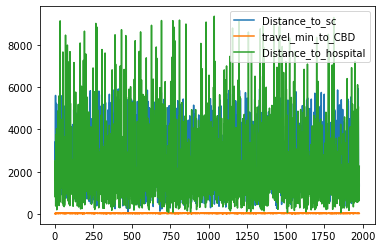

In [900]:
%matplotlib inline
reshape_df["Distance_to_sc"].plot().legend(), 
reshape_df["travel_min_to_CBD"].plot().legend(), 
reshape_df["Distance_to_hospital"].plot().legend()

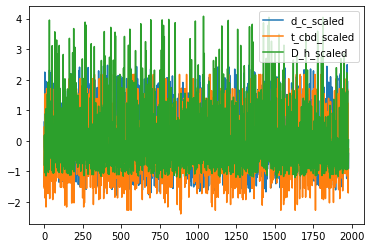

In [901]:
%matplotlib inline
reshape_df["d_c_scaled"].plot().legend(), 
reshape_df["t_cbd_scaled"].plot().legend(), 
reshape_df["D_h_scaled"].plot().legend()

(<matplotlib.legend.Legend at 0x7f816bc0ef10>,
 <matplotlib.legend.Legend at 0x7f8173e50070>)

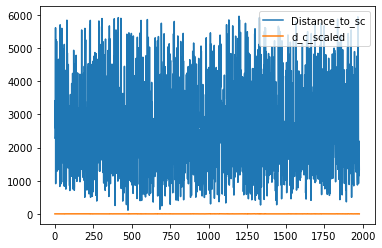

In [902]:
reshape_df["Distance_to_sc"].plot().legend(), reshape_df["d_c_scaled"].plot().legend()

(<matplotlib.legend.Legend at 0x7f819312c790>,
 <matplotlib.legend.Legend at 0x7f8173e84490>)

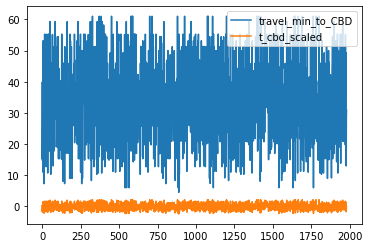

In [903]:
reshape_df["travel_min_to_CBD"].plot().legend(), reshape_df["t_cbd_scaled"].plot().legend()

(<matplotlib.legend.Legend at 0x7f819d2d7370>,
 <matplotlib.legend.Legend at 0x7f816b4e8ac0>)

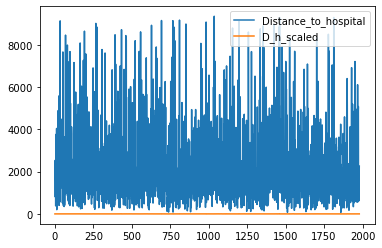

In [904]:
reshape_df["Distance_to_hospital"].plot().legend(), reshape_df["D_h_scaled"].plot().legend()

## Minmax normalization

Normalizing will ensure that a convergence problem does not have a massive variance, making optimization feasible.

In [929]:
minmax_scale = preprocessing.MinMaxScaler().fit_transform(reshape_df[['price','Distance_to_sc','travel_min_to_CBD', 'Distance_to_hospital']])
minmax_scale[0:5]


array([[0.31562602, 0.3720358 , 0.18569658, 0.08142841],
       [0.01299458, 0.38125244, 0.62648256, 0.25271934],
       [0.31158973, 0.56515598, 0.19100726, 0.26590434],
       [0.17839244, 0.42362503, 0.26978226, 0.17974762],
       [0.09127603, 0.9407006 , 0.53336874, 0.16231544]])

In [931]:
reshape_df['price_minmax'] = minmax_scale[:,2]
reshape_df['d_c_minmax'] = minmax_scale[:,0] 
reshape_df['t_cbd_minmax'] = minmax_scale[:,1]
reshape_df['D_h_minmax'] = minmax_scale[:,2]
reshape_df.head()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital,d_c_scaled,t_cbd_scaled,D_h_scaled,d_c_minmax,t_cbd_minmax,D_h_minmax,tran_sc,tcbd,t_hospital,price_minmax
0,15720000,2286.42,15.00,825.69,-0.191801,-1.541570,-0.789112,0.315626,0.372036,0.185697,54.4322,10.726,11.7387,0.185697
1,2224000,2340.32,39.90,2417.13,-0.152276,0.469029,0.117759,0.012995,0.381252,0.626483,54.9728,26.3504,15.0066,0.626483
2,15540000,3415.81,15.30,2539.63,0.636396,-1.517346,0.187565,0.311590,0.565156,0.191007,64.5009,10.9296,15.1704,0.191007
3,9600000,2588.12,19.75,1739.16,0.029440,-1.158022,-0.268577,0.178392,0.423625,0.269782,57.3678,13.8899,13.9474,0.269782
4,5715000,5612.04,34.64,1577.20,2.246923,0.044300,-0.360869,0.091276,0.940701,0.533369,79.4526,23.2091,13.643,0.533369


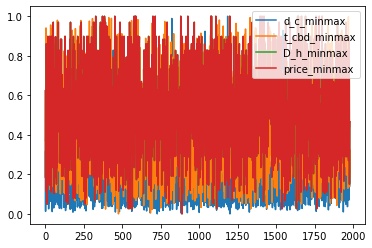

In [932]:
%matplotlib inline
reshape_df["d_c_minmax"].plot().legend(), 
reshape_df["t_cbd_minmax"].plot().legend(), 
reshape_df["D_h_minmax"].plot().legend(),
reshape_df["price_minmax"].plot().legend()

These attributes need to be scaled since the mean and variance seem to be very different for each. Each seems to have some outliers. The minimax method of normalization is very susceptible to outliers. Therefore, the StandardScaler method of normalization is a better way to go. 


We want to see the effect on the dependent variable with a cange in the independent variables. Therefore, we plot each variable against price and see how a couple of transformation methods affect the relationship.

# Transformations for `Distance_to_sc`

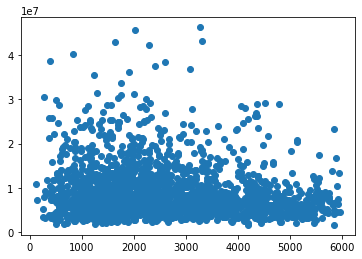

In [908]:
plt.scatter(reshape_df["Distance_to_sc"], reshape_df["price"])

### log Transformations

In [933]:
reshape_df['tran_sc'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_sc'].at[i] = math.log(reshape_df["Distance_to_sc"][i])
    i += 1
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_price'].at[i] = math.log(reshape_df["price"][i])
    i += 1

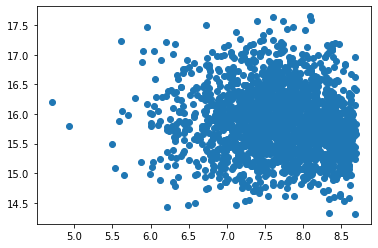

In [934]:
plt.scatter(reshape_df["tran_sc"], reshape_df["tran_price"]) 

### Power Transformation

In [946]:
reshape_df['tran_sc'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_sc'].at[i] = math.pow(reshape_df["Distance_to_sc"][i],2)
    i += 1   
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_price'].at[i] = math.pow(reshape_df["price"][i],2)
    i += 1   

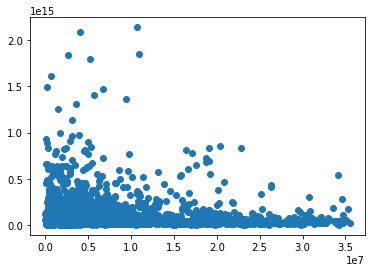

In [947]:
plt.scatter(reshape_df["tran_sc"], reshape_df["tran_price"]) 

### BOX-COX Transformation

In [948]:
from scipy import stats

reshape_df['tran_sc'] = None
i = 0
for row in reshape_df.iterrows():
    fitted_data, fitted_lambda = stats.boxcox(reshape_df["Distance_to_sc"]) 
    reshape_df['tran_sc'].at[i] = fitted_data[i]
    i += 1   

reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    fitted_data, fitted_lambda = stats.boxcox(reshape_df["price"]) 
    reshape_df['tran_price'].at[i] = fitted_data[i]
    i += 1  

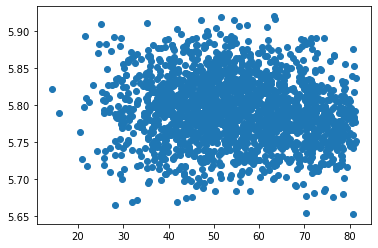

In [949]:
plt.scatter(reshape_df["tran_sc"], reshape_df["tran_price"]) 

# Transformations for `travel_min_to_CBD`

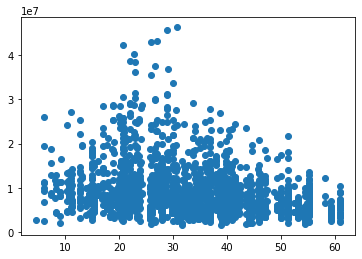

In [915]:
plt.scatter(reshape_df["travel_min_to_CBD"], reshape_df["price"])

### Log Transformation

In [950]:
reshape_df['tcbd'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tcbd'].at[i] = math.log(reshape_df["travel_min_to_CBD"][i])
    i += 1
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_price'].at[i] = math.log(reshape_df["price"][i])
    i += 1

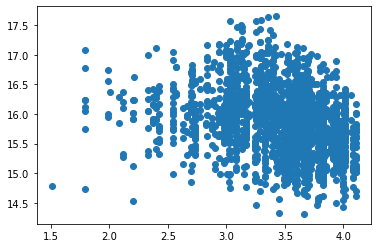

In [951]:
plt.scatter(reshape_df["tcbd"], reshape_df["tran_price"])

### Power Transformation

In [952]:
reshape_df['tcbd'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tcbd'].at[i] = math.pow(reshape_df["travel_min_to_CBD"][i],2)
    i += 1 
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_price'].at[i] = math.pow(reshape_df["price"][i],2)
    i += 1 

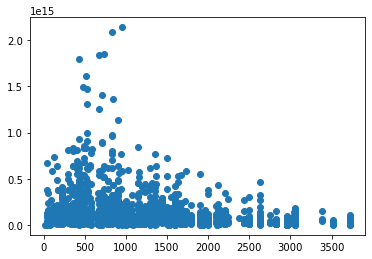

In [954]:
plt.scatter(reshape_df["tcbd"], reshape_df["tran_price"])

### Box-cox Transformation

In [955]:
reshape_df['tcbd'] = None
i = 0
for row in reshape_df.iterrows():
    fitted_data, fitted_lambda = stats.boxcox(reshape_df["travel_min_to_CBD"]) 
    reshape_df['tcbd'].at[i] = fitted_data[i]
    i += 1  
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    fitted_data, fitted_lambda = stats.boxcox(reshape_df["price"]) 
    reshape_df['tran_price'].at[i] = fitted_data[i]
    i += 1  

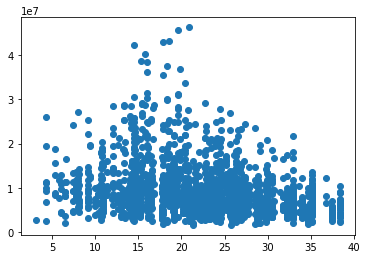

In [956]:
plt.scatter(reshape_df["tcbd"], reshape_df["price"])

# Transformations for `Distance_to_hospital`

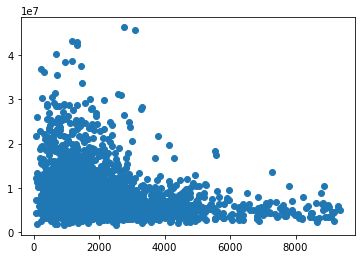

In [922]:
plt.scatter(reshape_df["Distance_to_hospital"], reshape_df["price"])

### log Transformation

In [957]:
reshape_df['t_hospital'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['t_hospital'].at[i] = math.log(reshape_df["Distance_to_hospital"][i])
    i += 1
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_price'].at[i] = math.log(reshape_df["price"][i])
    i += 1

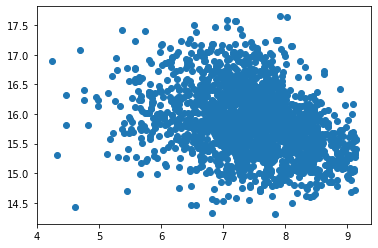

In [958]:
plt.scatter(reshape_df["t_hospital"], reshape_df["tran_price"])

### Power Transformation

In [959]:
reshape_df['t_hospital'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['t_hospital'].at[i] = math.pow(reshape_df["Distance_to_hospital"][i],2)
    i += 1 
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    reshape_df['tran_price'].at[i] = math.pow(reshape_df["price"][i],2)
    i += 1

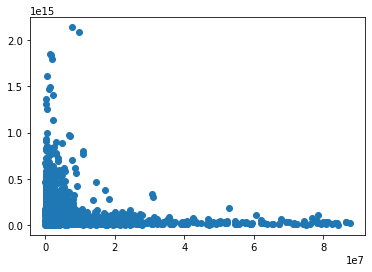

In [960]:
plt.scatter(reshape_df["t_hospital"], reshape_df["tran_price"])

### Box-COX Transformation

In [961]:
reshape_df['t_hospital'] = None
i = 0
for row in reshape_df.iterrows():
    fitted_data, fitted_lambda = stats.boxcox(reshape_df["Distance_to_hospital"]) 
    reshape_df['t_hospital'].at[i] = fitted_data[i]
    i += 1  
    
reshape_df['tran_price'] = None
i = 0
for row in reshape_df.iterrows():
    fitted_data, fitted_lambda = stats.boxcox(reshape_df["price"]) 
    reshape_df['tran_price'].at[i] = fitted_data[i]
    i += 1 

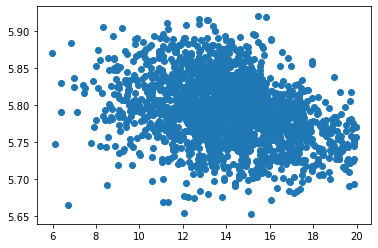

In [962]:
plt.scatter(reshape_df["t_hospital"], reshape_df["tran_price"])

- These attributes seem to be right or left skewed.As attrivutes are normally distribuated,Therefore, on observing the above output, we can see that in most cases we need to do transformation like `log`,`power` or `Box-Cox`.
- But after appling this transformation we can stronglly suggest thta, using `Box-cox` transformation is best for predictiong class variable when we fit linear regression model.

## Referances

- https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832
- https://www.geeksforgeeks.org/box-cox-transformation-using-python/
- https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc